<a href="https://colab.research.google.com/github/st148385/ACDC_3D_2Dslices/blob/main/lr_Scheduling_niftiSave_Unet_ACDC_3D_2DsliceTraining_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.6 MB/s eta 0:00:00


## Setup imports

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

import monai
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    SqueezeDimd,
    Resized,
    ResizeWithPadOrCropd,
    EnsureTyped,
    RandSpatialCropSamplesd,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 1.2.dev2311
Numpy version: 1.22.4
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 137fb89c249dbc6146f69e3a48157239853a66a9
MONAI __file__: /usr/local/lib/python3.9/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.11.2
gdown version: 4.4.0
TorchVision version: 0.14.1+cu116
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.4.8
pandas version: 1.4.4
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-re

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ["MONAI_DATA_DIRECTORY"] = "/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC"

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC


## Setup transforms for training and validation

(Auch interessant, copy items, diese haben dann verschiedene keys (comment in https://github.com/Project-MONAI/MONAI/discussions/3707): \\
```LoadImaged(keys="img"), 
EnsureChannelFirstd(keys="img"), 
CopyItemsd(keys="img", times=3),
SpatialCropd(keys="img", roi_start=..., roi_end=...),
SpatialCropd(keys="img_0", roi_start=..., roi_end=...),
SpatialCropd(keys="img_1", roi_start=..., roi_end=...),
SpatialCropd(keys="img_2", roi_start=..., roi_end=...),)```

In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(96, 96, 16),
        #     pos=1,
        #     neg=1,
        #     # num_samples=4,
        #     num_samples=1,
        #     image_key="image",
        #     image_threshold=0,
        # ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        EnsureTyped(keys=["image", "label"]), # newly added
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

/usr/local/lib/python3.9/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [5]:
# data_dir = "/dataset/"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
data_dir = (directory + "/")
print(f"In meinem Colab Folder sind folgende Inhalte: {os.listdir(data_dir)}")
split_json = "dataset_ACDC_MONAI.json"

datasets = data_dir + split_json

datalist = load_decathlon_datalist(datasets, True, "training")  # Guckt sich hier dann an, was im json genau dieses "training" (oder "validation" oder "test") sein soll

print(f"Example what contents are in the 'datalist' dicitionary for training: {datalist[17]}")

val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    # cache_num=24,
    # cache_rate=1.0,
    num_workers=4,
)

#print(f"Example what contents are in the 'train_ds' dicitionary for training: {train_ds[17]}")

train_loader0 = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)


check_data = monai.utils.misc.first(train_loader0)
print("first volume's shape for training: ", check_data["image"].shape, check_data["label"].shape)
print("Erinnerung: Ich mache hier bei der transform <RandCropByPosNegLabeld> vier samples. Daher ist bei batch_size = 1 die Dimension <0> = 4 und z. B. bei batch_size=8 ist diese Dimension <0> 4*8=32")
check_data = monai.utils.misc.first(val_loader)
print("first volume's shape for validation: ", check_data["image"].shape, check_data["label"].shape)

In meinem Colab Folder sind folgende Inhalte: ['imagesTr', 'labelsTr', 'imagesTs', 'dataset.json', 'labelsTs', '20ep_seed10_segresnet_05_03_23_best_metric_model.pth', 'best_metric_model.pth', 'labelsVal', 'imagesVal', 'dataset_ACDC_MONAI.json', 'best_metric_model_ACDC_3D_10000iterations_btcv.pth', '0Result_unetr_ACDC_3D.pdf', '1Result_unetr_ACDC_3D.pdf', '2Result_unetr_ACDC_3D.pdf', '3Result_unetr_ACDC_3D.pdf', '4Result_unetr_ACDC_3D.pdf', 'dataset_ACDC_MONAI_2D.json', 'LossAndDiceScoreOverIterations_unetr_ACDC_3D.pdf', 'best_metric_model_ACDC_2D_10000iterations_39min.pth', 'best_metric_model_ACDC_2D_10000it_65min_randSpatialCrop_Resize_8samples.pth', 'best_metric_model_ACDC_2D.pth', 'LossAndDiceScoreOverIterations_unetr_ACDC_2D.pdf', '0Result_Test_unetr_ACDC_2D.pdf', '1Result_Test_unetr_ACDC_2D.pdf', '2Result_Test_unetr_ACDC_2D.pdf', '3Result_Test_unetr_ACDC_2D.pdf', '4Result_Test_unetr_ACDC_2D.pdf', '0Result_unetr_ACDC_2D.pdf', '1Result_unetr_ACDC_2D.pdf', '2Result_unetr_ACDC_2D.pdf'

Loading dataset: 100%|██████████| 35/35 [00:24<00:00,  1.43it/s]
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid p

first volume's shape for training:  torch.Size([1, 1, 175, 233, 51]) torch.Size([1, 1, 175, 233, 51])
Erinnerung: Ich mache hier bei der transform <RandCropByPosNegLabeld> vier samples. Daher ist bei batch_size = 1 die Dimension <0> = 4 und z. B. bei batch_size=8 ist diese Dimension <0> 4*8=32
first volume's shape for validation:  torch.Size([1, 1, 208, 247, 36]) torch.Size([1, 1, 208, 247, 36])


In [6]:
#print(train_ds[1])

WidthLength = 16*6

patch_func = monai.data.PatchIterd(
    keys=["image", "label"], patch_size=(None, None, 1), start_pos=(0, 0, 0)  # dynamic first two dimensions
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["image", "label"], dim=-1),  # squeeze the last dim
        # Resized(keys=["image", "label"], spatial_size=[96, 96]),
        # to use crop/pad instead of resize:
        # ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=[96, 96], mode="replicate", num_samples = 4,)    # terrible results
        # RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(WidthLength, WidthLength),
        #     pos=1,
        #     neg=1,
        #     # num_samples=4,
        #     num_samples=8,
        #     image_key="image",
        #     image_threshold=0,
        #     random_size=True
        # ),
        # RandSpatialCropSamplesd(keys=["image", "label"], roi_size=[32, 32], max_roi_size=[16*8, 16*8], num_samples = 8, random_size = True),
        # Resized(keys=["image", "label"], spatial_size=[WidthLength, WidthLength]),
        RandSpatialCropSamplesd(keys=["image", "label"], roi_size=[WidthLength, WidthLength], num_samples = 8),
        Resized(keys=["image", "label"], spatial_size=[WidthLength, WidthLength]),
    ]
)
patch_ds = monai.data.GridPatchDataset(
    data=train_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False
)
shuffle_ds = monai.data.ShuffleBuffer(patch_ds, buffer_size=30)#, seed=0)
train_loader = DataLoader(
    shuffle_ds,
    # patch_ds,
    batch_size=5,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)

print(train_loader)

check_data = monai.utils.misc.first(train_loader)
print("first patch's shape: ", check_data["image"].shape, check_data["label"].shape)

/usr/local/lib/python3.9/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary RandSpatialCropSamplesd.__init__:random_size: Current default value of argument `random_size=True` has been deprecated since version 1.1. It will be changed to `random_size=False` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


first patch's shape:  torch.Size([40, 1, 96, 96]) torch.Size([40, 1, 96, 96])


## Check data shape and visualize

image shape: torch.Size([1, 208, 247, 36]), label shape: torch.Size([1, 208, 247, 36])


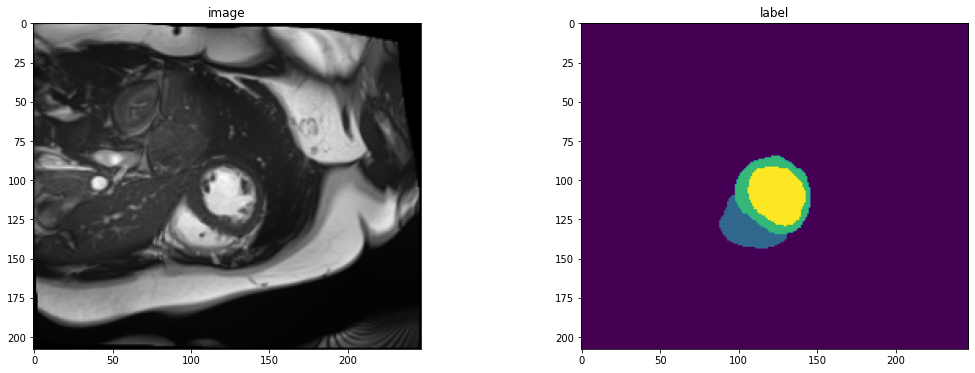

In [7]:
slice_map = {
    # "img0035.nii.gz": 170,
    "patient036_frame01.nii.gz": 13,
    "patient037_frame01.nii.gz": 18,
    "patient038_frame01.nii.gz": 22,
    "patient039_frame01.nii.gz": 9,
    "patient040_frame01.nii.gz": 15,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create 2D Model, Loss for multi-class problem and Optimizer


In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = UNETR(
#     in_channels=1,
#     out_channels=4,   # was 14 for btcv
#     img_size=WidthLength,  # was (96, 96, 96)
#     feature_size=16,
#     hidden_size=768,
#     mlp_dim=3072,
#     num_heads=12,
#     pos_embed="perceptron",
#     norm_name="instance",
#     res_block=True,
#     dropout_rate=0.0,
#     spatial_dims=2,
# ).to(device)

model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# TODO: Learning rate scheduling verwenden? (Z. B. von meiner BA)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)
CosineScheduling = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer = optimizer, T_0=100, T_mult=2, eta_min=0, last_epoch=-1, verbose=False) # Durch t_mult=2 wird die Periodendauer des Cosinus langsam länger (=Freq sinkt)

# lrs = []

# for i in range(10000):
#     CosineScheduling.step()
#     lrs.append(
#         optimizer.param_groups[0]["lr"]
#     )
# plt.plot(lrs)

### Execute a typical PyTorch training process 
(3D Training: 10000 iterations with 35 training and 5 validation images takes -> about 1h 45min)

(2D Training: 10000 iteration with 35 training (3D) and 8 num_samples des random crops -> about 2 * 45 min)

(Iterations are the number of batches needed to complete one epoch. Example: 2000 train images with a batch size of 500 takes 4 iterations to complete 1 epoch)

In [ ]:
def validation(epoch_iterator_val):
    model.eval()            # Don't update model parameters   // Gegenteil von model.train()
    with torch.no_grad():   # Disable gradient evaluation
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            
            slice_inferer = monai.inferers.SliceInferer(
                                        roi_size=(WidthLength, WidthLength),
                                        sw_batch_size=3,
                                        spatial_dim=2,  # Spatial dim to slice along is defined here -> 0 axial, 1 coronal, 2 sagittal  ## https://docs.monai.io/en/stable/inferers.html
                                        device=torch.device("cuda"),
                                        padding_mode="replicate",
                                        )
            val_outputs = slice_inferer(val_inputs, model).to(device)
            val_labels_list = decollate_batch(val_labels)                                           # Mit allen 2D Slices des 3D Trainingsbildes kann ich wieder alle 2D Slices des 3D ground truth labels nehmen

            ## Alternativ nur 1 2D slice verwenden:
            # val_outputs = sliding_window_inference(val_inputs[:,:,:,:,0], (96, 96), 4, model)     # Das 2D Model benötigt auch 2D Validation Data, 3D validation Data geht nicht! Hier entsprechend nur 1 2D Slice des 3D Bildes
            # val_labels_list = decollate_batch(val_labels[:,:,:,:,0])                              # Wenn ich nur einen 2D Slice des Trainingsbildes habe, dann darf ich auch nur den 2D Slice des dazugehörigen labels nehmen

            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()       # set model to train mode
    epoch_loss = 0
    step = 0
    # initialize progress bar with tqdm and train_loader
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        # get the input data and labels from the batch and move them to the GPU
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        # forward pass through the model to get the logits
        logit_map = model(x)
        # calculate the loss
        loss = loss_function(logit_map, y)
        # perform backpropagation to compute the gradients
        loss.backward()
        # accumulate the epoch loss
        epoch_loss += loss.item()
        ###
        # learning rate update
        CosineScheduling.step()
        ###
        # update the model parameters using the optimizer
        optimizer.step()
        # reset the gradients
        optimizer.zero_grad()
        # update the progress bar with the current loss and step number
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        # evaluate the model every eval_num steps (and/or at max_iterations)
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            # calculate the validation dice coefficient
            dice_val = validation(epoch_iterator_val)
            # compute the average loss for the epoch
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            # if the current dice coefficient is better than the best one seen so far, save the model
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_ACDC_2D.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

epoch = 35 # num_training_files
# 35 examples with a batch size of 5 means that it will take 7 iterations to complete 1 epoch. -> 10000 iterations are 1400 epochs?? // 10E3 / (35/5) = 10000 / 7
# But I have 35 * slice_num * num_samples_from_random_crop examples? So with a slice_num of about 40 -> 10000 iterations are about 10000_{iterations} * 5_{batch_size} / (35_{3Dexamples} * 40_{slice_num} * 8_{crop_samples})
# = 10E3 * 5 / (35*40*8) => 4.5 Epochen?
# So I have about 35 * 40 2D slices which I'm taking 8 randomly cropped samples from. -> 11200 examples. Those are put into batches of size 5 -> 2240 batches -> I train over 4 epochs.
max_iterations = 10000 # ~285 * epoch
eval_num = 500
post_label = AsDiscrete(to_onehot=4)
post_pred = AsDiscrete(argmax=True, to_onehot=4)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)  # the actual training

Training (154 / 10000 Steps) (loss=0.72695): : 155it [01:03,  2.46it/s]
Training (309 / 10000 Steps) (loss=0.56267): : 155it [00:59,  2.62it/s]
Training (464 / 10000 Steps) (loss=0.33814): : 155it [01:01,  2.52it/s]
Training (500 / 10000 Steps) (loss=0.49218): : 35it [00:15,  3.31it/s]
Validate (465 / 10 Steps): 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]
Training (501 / 10000 Steps) (loss=0.39119): : 36it [00:26,  3.09s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4192780554294586 Current Avg. Dice: 0.4192780554294586


Training (619 / 10000 Steps) (loss=0.26116): : 155it [01:09,  2.23it/s]
Training (774 / 10000 Steps) (loss=0.27458): : 155it [01:01,  2.53it/s]
Training (929 / 10000 Steps) (loss=0.24772): : 155it [01:00,  2.55it/s]
Training (1000 / 10000 Steps) (loss=0.29412): : 70it [00:29,  3.47it/s]
Validate (930 / 10 Steps): 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]
Training (1001 / 10000 Steps) (loss=0.30993): : 71it [00:39,  3.34s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5209883451461792 Current Avg. Dice: 0.5209883451461792


Training (1084 / 10000 Steps) (loss=0.22060): : 155it [01:09,  2.22it/s]
Training (1239 / 10000 Steps) (loss=0.20061): : 155it [00:58,  2.63it/s]
Training (1394 / 10000 Steps) (loss=0.18659): : 155it [01:00,  2.56it/s]
Training (1500 / 10000 Steps) (loss=0.35570): : 105it [00:44,  2.68it/s]
Validate (1395 / 10 Steps): 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]
Training (1502 / 10000 Steps) (loss=0.42934): : 108it [00:54,  1.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5209883451461792 Current Avg. Dice: 0.3902673125267029


Training (1549 / 10000 Steps) (loss=0.21345): : 155it [01:10,  2.20it/s]
Training (1704 / 10000 Steps) (loss=0.20056): : 155it [01:00,  2.54it/s]
Training (1859 / 10000 Steps) (loss=0.19955): : 155it [00:59,  2.62it/s]
Training (2000 / 10000 Steps) (loss=0.24505): : 140it [00:56,  3.40it/s]
Validate (1860 / 10 Steps): 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]
Training (2002 / 10000 Steps) (loss=0.20936): : 142it [01:06,  2.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6760610938072205 Current Avg. Dice: 0.6760610938072205


Training (2014 / 10000 Steps) (loss=0.18809): : 155it [01:08,  2.25it/s]
Training (2169 / 10000 Steps) (loss=0.18909): : 155it [01:00,  2.55it/s]
Training (2324 / 10000 Steps) (loss=0.17061): : 155it [01:00,  2.58it/s]
Training (2479 / 10000 Steps) (loss=0.16573): : 155it [01:00,  2.56it/s]
Training (2500 / 10000 Steps) (loss=0.22041): : 20it [00:10,  2.36it/s]
Validate (2480 / 10 Steps): 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]
Training (2502 / 10000 Steps) (loss=0.24650): : 21it [00:19,  3.03s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6760610938072205 Current Avg. Dice: 0.6555374264717102


Training (2634 / 10000 Steps) (loss=0.16014): : 155it [01:10,  2.20it/s]
Training (2789 / 10000 Steps) (loss=0.15159): : 155it [00:58,  2.65it/s]
Training (2944 / 10000 Steps) (loss=0.14112): : 155it [01:01,  2.54it/s]
Training (3000 / 10000 Steps) (loss=0.23453): : 55it [00:26,  1.85it/s]
Validate (2945 / 10 Steps): 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]
Training (3001 / 10000 Steps) (loss=0.17792): : 56it [00:34,  3.26s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7026613354682922 Current Avg. Dice: 0.7026613354682922


Training (3099 / 10000 Steps) (loss=0.15043): : 155it [01:10,  2.20it/s]
Training (3254 / 10000 Steps) (loss=0.17099): : 155it [01:00,  2.57it/s]
Training (3409 / 10000 Steps) (loss=0.15715): : 155it [01:00,  2.54it/s]
Training (3500 / 10000 Steps) (loss=0.18032): : 90it [00:35,  2.81it/s]
Validate (3410 / 10 Steps): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]
Training (3502 / 10000 Steps) (loss=0.22325): : 91it [00:45,  3.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7026613354682922 Current Avg. Dice: 0.5787784457206726


Training (3564 / 10000 Steps) (loss=0.16050): : 155it [01:08,  2.26it/s]
Training (3719 / 10000 Steps) (loss=0.16008): : 155it [00:58,  2.66it/s]
Training (3874 / 10000 Steps) (loss=0.14726): : 155it [01:00,  2.56it/s]
Training (4000 / 10000 Steps) (loss=0.19461): : 125it [00:50,  3.44it/s]
Validate (3875 / 10 Steps): 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]
Training (4001 / 10000 Steps) (loss=0.15757): : 126it [01:00,  3.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7026613354682922 Current Avg. Dice: 0.6921793222427368


Training (4029 / 10000 Steps) (loss=0.16064): : 155it [01:07,  2.28it/s]
Training (4184 / 10000 Steps) (loss=0.15387): : 155it [00:59,  2.59it/s]
Training (4339 / 10000 Steps) (loss=0.15421): : 155it [01:00,  2.56it/s]
Training (4494 / 10000 Steps) (loss=0.14875): : 155it [00:58,  2.63it/s]
Training (4500 / 10000 Steps) (loss=0.22251): : 5it [00:06,  1.27it/s]
Validate (4495 / 10 Steps): 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]
Training (4502 / 10000 Steps) (loss=0.22279): : 8it [00:15,  1.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7026613354682922 Current Avg. Dice: 0.6825557351112366


Training (4649 / 10000 Steps) (loss=0.14697): : 155it [01:08,  2.26it/s]
Training (4804 / 10000 Steps) (loss=0.13062): : 155it [01:00,  2.56it/s]
Training (4959 / 10000 Steps) (loss=0.12751): : 155it [01:00,  2.57it/s]
Training (5000 / 10000 Steps) (loss=0.21248): : 40it [00:17,  3.63it/s]
Validate (4960 / 10 Steps): 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]
Training (5002 / 10000 Steps) (loss=0.15052): : 43it [00:27,  1.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7026613354682922 Current Avg. Dice: 0.6403099298477173


Training (5114 / 10000 Steps) (loss=0.12361): : 155it [01:09,  2.24it/s]
Training (5269 / 10000 Steps) (loss=0.11878): : 155it [01:00,  2.56it/s]
Training (5424 / 10000 Steps) (loss=0.11803): : 155it [01:00,  2.57it/s]
Training (5500 / 10000 Steps) (loss=0.14737): : 75it [00:30,  2.66it/s]
Validate (5425 / 10 Steps): 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]
Training (5501 / 10000 Steps) (loss=0.14951): : 76it [00:40,  3.01s/it]

Model Was Saved ! Current Best Avg. Dice: 0.70319664478302 Current Avg. Dice: 0.70319664478302


Training (5579 / 10000 Steps) (loss=0.11415): : 155it [01:09,  2.24it/s]
Training (5734 / 10000 Steps) (loss=0.11336): : 155it [00:58,  2.64it/s]
Training (5889 / 10000 Steps) (loss=0.11033): : 155it [01:00,  2.58it/s]
Training (6000 / 10000 Steps) (loss=0.14900): : 110it [00:45,  3.38it/s]
Validate (5890 / 10 Steps): 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]
Training (6001 / 10000 Steps) (loss=0.12025): : 112it [00:55,  2.35s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7033899426460266 Current Avg. Dice: 0.7033899426460266


Training (6044 / 10000 Steps) (loss=0.11198): : 155it [01:07,  2.28it/s]
Training (6199 / 10000 Steps) (loss=0.12393): : 155it [01:00,  2.55it/s]
Training (6354 / 10000 Steps) (loss=0.12574): : 155it [01:00,  2.57it/s]
Training (6500 / 10000 Steps) (loss=0.21643): : 145it [00:59,  3.33it/s]
Validate (6355 / 10 Steps): 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]
Training (6502 / 10000 Steps) (loss=0.31583): : 148it [01:08,  1.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7033899426460266 Current Avg. Dice: 0.6448591947555542


Training (6509 / 10000 Steps) (loss=0.15256): : 155it [01:09,  2.23it/s]
Training (6664 / 10000 Steps) (loss=0.13761): : 155it [01:00,  2.57it/s]
Training (6819 / 10000 Steps) (loss=0.15113): : 155it [00:57,  2.67it/s]
Training (6974 / 10000 Steps) (loss=0.13103): : 155it [01:00,  2.56it/s]
Training (7000 / 10000 Steps) (loss=0.19609): : 25it [00:13,  1.59it/s]
Validate (6975 / 10 Steps): 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]
Training (7002 / 10000 Steps) (loss=0.18904): : 28it [00:24,  2.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7033899426460266 Current Avg. Dice: 0.6853127479553223


Training (7129 / 10000 Steps) (loss=0.13034): : 155it [01:09,  2.22it/s]
Training (7284 / 10000 Steps) (loss=0.12879): : 155it [01:00,  2.57it/s]
Training (7439 / 10000 Steps) (loss=0.12442): : 155it [01:00,  2.55it/s]
Training (7500 / 10000 Steps) (loss=0.12496): : 60it [00:25,  2.63it/s]
Validate (7440 / 10 Steps): 100%|██████████| 5/5 [00:11<00:00,  2.30s/it]
Training (7502 / 10000 Steps) (loss=0.15777): : 63it [00:37,  2.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7033899426460266 Current Avg. Dice: 0.6967998147010803


Training (7594 / 10000 Steps) (loss=0.13490): : 155it [01:08,  2.25it/s]
Training (7749 / 10000 Steps) (loss=0.12248): : 155it [01:00,  2.58it/s]
Training (7904 / 10000 Steps) (loss=0.11790): : 155it [01:00,  2.57it/s]
Training (8000 / 10000 Steps) (loss=0.15499): : 95it [00:38,  2.57it/s]
Validate (7905 / 10 Steps): 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
Training (8001 / 10000 Steps) (loss=0.19997): : 97it [00:47,  2.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7033899426460266 Current Avg. Dice: 0.6836747527122498


Training (8059 / 10000 Steps) (loss=0.11465): : 155it [01:09,  2.24it/s]
Training (8214 / 10000 Steps) (loss=0.10914): : 155it [01:00,  2.58it/s]
Training (8369 / 10000 Steps) (loss=0.10549): : 155it [00:59,  2.60it/s]
Training (8500 / 10000 Steps) (loss=0.14470): : 130it [00:52,  1.92it/s]
Validate (8370 / 10 Steps): 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]
Training (8502 / 10000 Steps) (loss=0.12500): : 133it [01:01,  1.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7033899426460266 Current Avg. Dice: 0.6902819871902466


Training (8524 / 10000 Steps) (loss=0.10871): : 155it [01:09,  2.23it/s]
Training (8679 / 10000 Steps) (loss=0.10520): : 155it [00:58,  2.66it/s]
Training (8834 / 10000 Steps) (loss=0.10303): : 155it [01:00,  2.57it/s]
Training (8989 / 10000 Steps) (loss=0.11006): : 155it [01:00,  2.58it/s]
Training (9000 / 10000 Steps) (loss=0.20243): : 10it [00:05,  2.92it/s]
Validate (8990 / 10 Steps): 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]
Training (9002 / 10000 Steps) (loss=0.12341): : 13it [00:16,  1.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7033899426460266 Current Avg. Dice: 0.6664508581161499


Training (9144 / 10000 Steps) (loss=0.10025): : 155it [01:08,  2.28it/s]
Training (9299 / 10000 Steps) (loss=0.11071): : 155it [01:01,  2.53it/s]
Training (9454 / 10000 Steps) (loss=0.09536): : 155it [00:59,  2.59it/s]
Training (9500 / 10000 Steps) (loss=0.13844): : 45it [00:19,  2.69it/s]
Validate (9455 / 10 Steps): 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]
Training (9502 / 10000 Steps) (loss=0.11511): : 48it [00:29,  1.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7033899426460266 Current Avg. Dice: 0.6670120358467102


Training (9609 / 10000 Steps) (loss=0.09479): : 155it [01:09,  2.23it/s]
Training (9764 / 10000 Steps) (loss=0.08980): : 155it [01:00,  2.57it/s]
Training (9919 / 10000 Steps) (loss=0.09291): : 155it [00:59,  2.59it/s]
Training (10000 / 10000 Steps) (loss=0.14558): : 80it [00:32,  3.39it/s]
Validate (9920 / 10 Steps): 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]
Training (10002 / 10000 Steps) (loss=0.13076): : 83it [00:42,  1.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7033899426460266 Current Avg. Dice: 0.6899391412734985


Training (10074 / 10000 Steps) (loss=0.08888): : 155it [01:08,  2.27it/s]


Given:

    35 3D training examples
    Each 3D training example has 20 2D slices used for training
    Each 2D slice is randomly cropped to generate 8 samples
    Batch size of 5
    Total number of iterations: 10000

Let's calculate the total number of samples:

    Each 3D training example contributes 20 x 8 = 160 samples
    With 35 3D training examples, the total number of samples is 35 x 160 = 5600

Now let's calculate the number of epochs:

    Batch size of 5 means we need 5600 / 5 = 1120 batches to cover all samples in one epoch
    10000 iterations would cover 10000 / 1120 = 8.93 epochs

So the model was trained for approximately 8.93 epochs.

In [11]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_ACDC_2D.pth")))

<All keys matched successfully>

In [12]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

NameError: ignored

### Plot the loss and metric - for every 500 iterations due to eval_num = 500

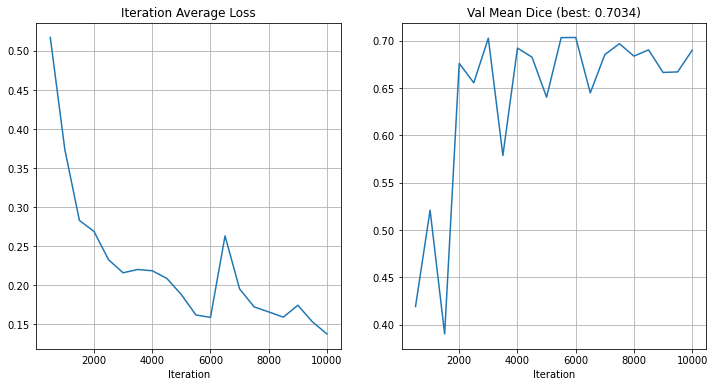

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.grid()
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice (best: %.4f)" %(dice_val_best))
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.grid()
plt.savefig(os.path.join(root_dir, "LossAndDiceScoreOverIterations_unetr_ACDC_2D.pdf"))
plt.show()

### Check best model output with the input image and label

Before the third to last line of code, "val_outputs" is currently a MetaTensor of shape (1, 4, W, L). What does torch.argmax(val_outputs, dim=1) do?

→ torch.argmax(val_outputs, dim=1) is a PyTorch function that returns the indices of the maximum values along the specified dimension, which in this case is the second dimension (index 1), i.e. the 4 channels/labels.

→ Since the val_output tensor has shape (1, 4, 206, 253), this function will return a new tensor of shape (1, 206, 253), where each element in the tensor corresponds to the index of the maximum value along the second dimension. In other words, it returns the predicted label index (out of the four possible labels) for each pixel in the 2D slice.

Taking testABC = 3


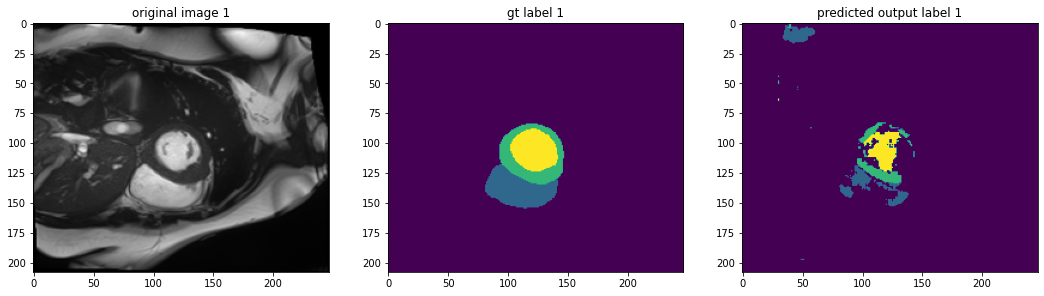

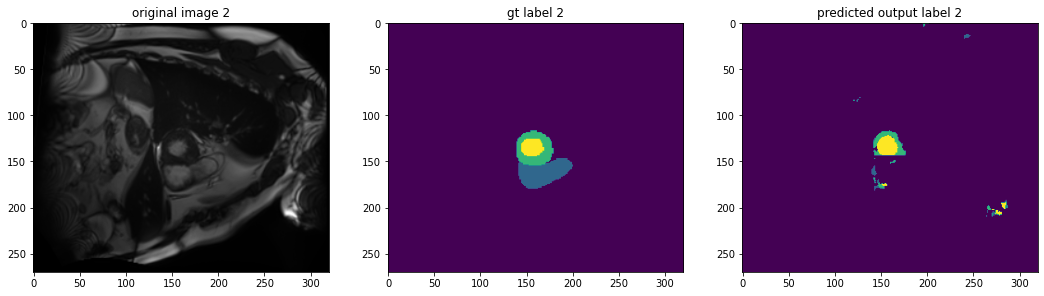

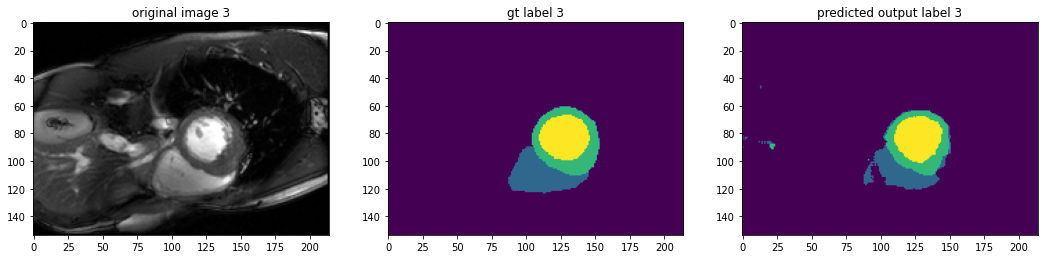

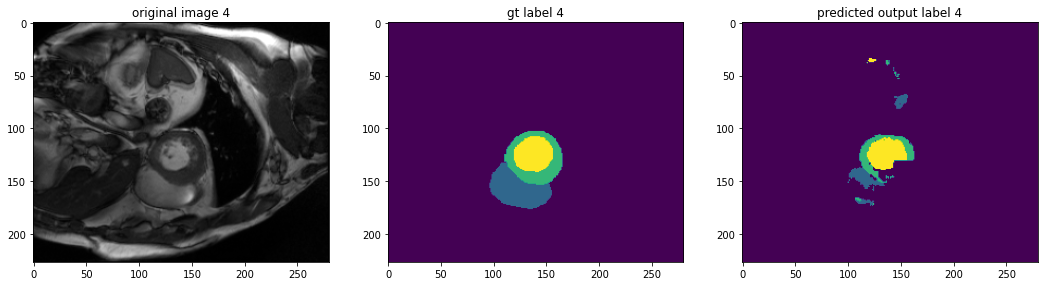

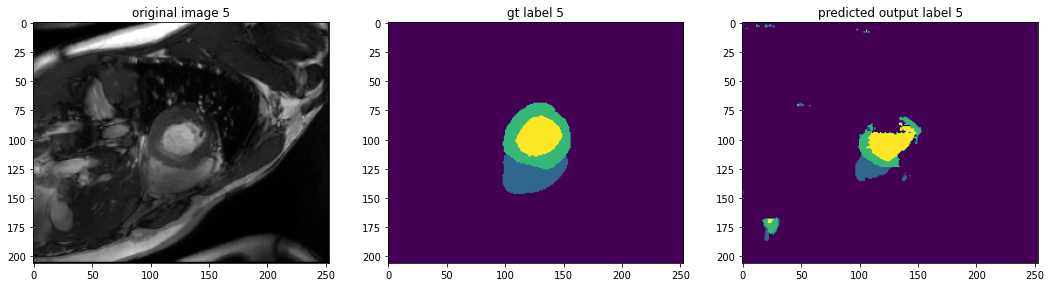

In [13]:
import random
# testABC = slice_map[img_name]
testABC = random.randint(0,10)
print(f"Taking testABC = {testABC}")
for case_num in [0,1,2,3,4]:
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_ACDC_2D.pth"))) # "best_metric_model_ACDC_2D_10074iterations_88min_8RandomCropSamples.pth"
  model.eval()
  with torch.no_grad():
      img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
      img = val_ds[case_num]["image"]
      label = val_ds[case_num]["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      # val_outputs = sliding_window_inference(val_inputs[:,:,:,:,0], (WidthLength, WidthLength), 4, model, overlap=0.8)
      slice_inferer = monai.inferers.SliceInferer(
                                        roi_size=(WidthLength, WidthLength),
                                        sw_batch_size=3,
                                        spatial_dim=2,  # Spatial dim to slice along is defined here -> 0 axial, 1 coronal, 2 sagittal  ## https://docs.monai.io/en/stable/inferers.html
                                        device=torch.device("cuda"),
                                        padding_mode="replicate",
                                        )
      val_outputs = slice_inferer(val_inputs, model).to(device)
      plt.figure("check", (18, 6))
      plt.subplot(1, 3, 1)
      plt.title("original image %i" %(case_num+1))
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, testABC], cmap="gray")
      plt.subplot(1, 3, 2)
      plt.title("gt label %i" %(case_num+1))
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, testABC])
      plt.subplot(1, 3, 3)
      plt.title("predicted output label %i" %(case_num+1))
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, testABC])
      # plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :])
      plt.savefig(os.path.join(root_dir, str(case_num) + "Result_unetr_ACDC_2D.pdf"))
      plt.show()


Test Images laden

In [14]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"],
                pixdim=(1.5, 1.5, 2.0),
                ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_files = load_decathlon_datalist(datasets, False, "test")

print(test_files)

#print(f"Example what contents are in the 'train_ds' dicitionary for training: {train_ds[17]}")

test_ds = CacheDataset(data=test_files, transform=test_transforms, num_workers=4)    # ohne eine transform mit loadImaged bleibt der Eintrag eine Liste mit dem path/to/file/patient.nii.gz
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=torch.cuda.is_available())

check_test_data = monai.utils.misc.first(test_loader)
print(check_test_data.keys())

print("first volume's shape for test/inference: ", check_test_data["image"].shape)
# print("first volume's shape for test/inference: ", check_test_data["image"].shape, check_test_data["label"].shape)

print(f"Im test_loader befinden sich nun {len(test_loader)} Elemente")

/usr/local/lib/python3.9/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


[{'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient041_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient043_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient042_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient044_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient048_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient047_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient046_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient049_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Ta

Loading dataset: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dict_keys(['image', 'image_meta_dict', 'foreground_start_coord', 'foreground_end_coord'])
first volume's shape for test/inference:  torch.Size([1, 1, 183, 266, 26])
Im test_loader befinden sich nun 10 Elemente


Test Images überprüfen

(und 3D nifti files (.nii.gz) aus 2D slice outputs des models speichern)

/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/labelsTs/patient041_frame01_gt.nii.gz
[[-1. -0.  0.  0.]
 [-0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
Taking testABC = 19


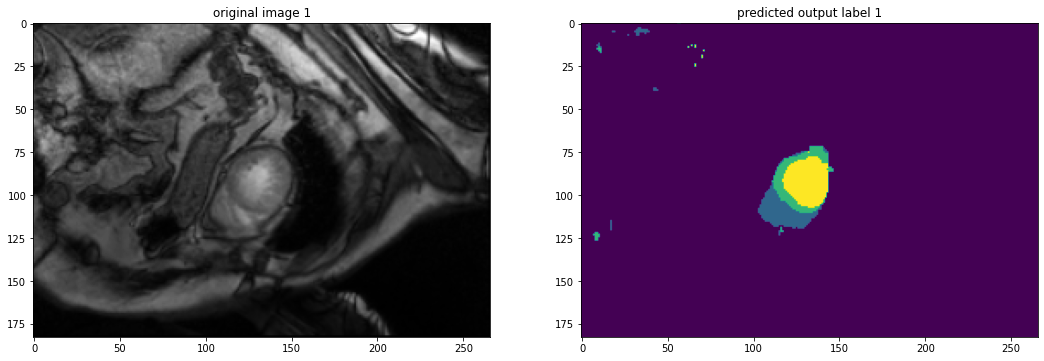

Name: seg0.nii.gz
Path: /content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/output
Unique values: [0 1 2 3]
Counts: [1212948   18112   13944   20624]
Taking testABC = 3


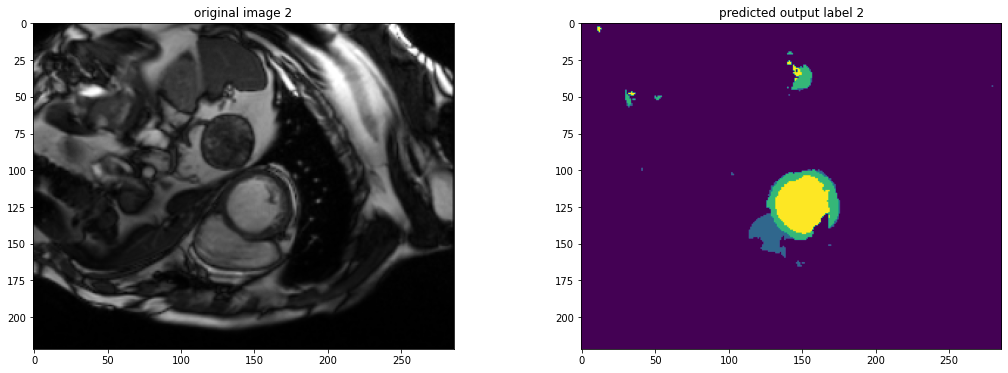

Name: seg1.nii.gz
Path: /content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/output
Unique values: [0 1 2 3]
Counts: [2281344   12789   22631   32440]
Taking testABC = 15


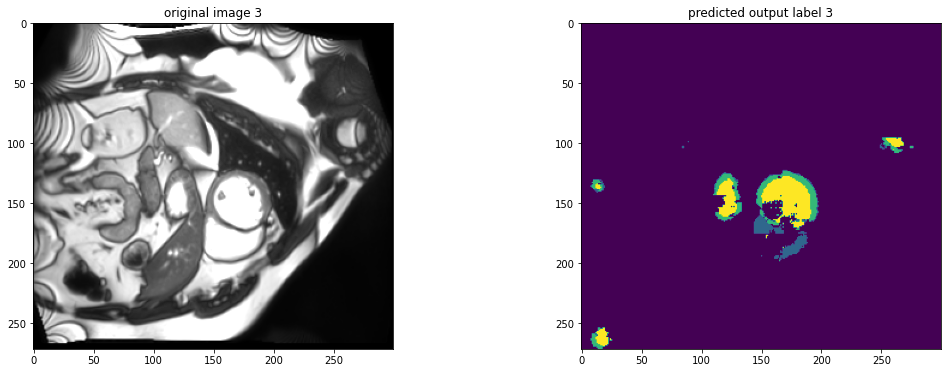

Name: seg2.nii.gz
Path: /content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/output
Unique values: [0 1 2 3]
Counts: [3252239   18136   27451   47774]
Taking testABC = 20


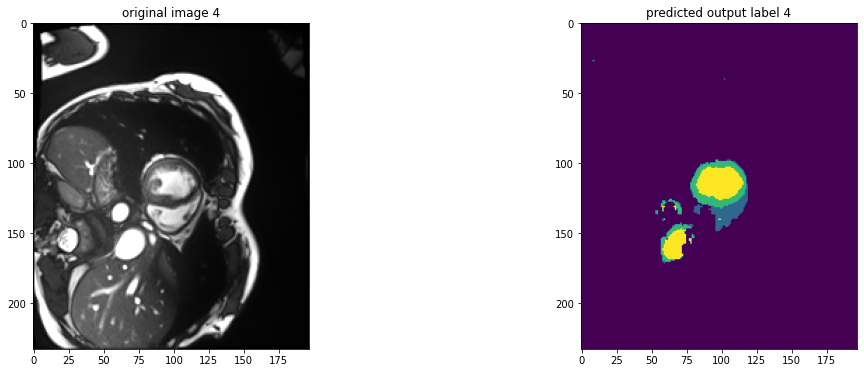

Name: seg3.nii.gz
Path: /content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/output
Unique values: [0 1 2 3]
Counts: [1818036   16025   19705   28175]
Taking testABC = 17


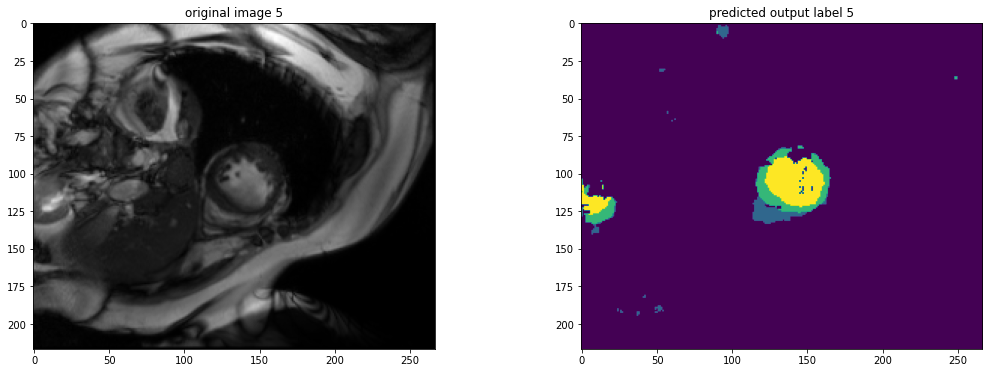

Name: seg4.nii.gz
Path: /content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/output
Unique values: [0 1 2 3]
Counts: [2020792    9098   23342   32572]


In [18]:
import random
# testABC = slice_map[img_name]

## Get affine matrix of test labels
import nibabel as nib
import numpy as np

# Load the nifti file
nifti_path = os.path.join(root_dir, "labelsTs", "patient041_frame01_gt.nii.gz")
print(nifti_path)
nifti_img = nib.load(nifti_path)

# Get the affine matrix
affine_matrix = nifti_img.affine

print(affine_matrix)

# Show some 2D slice examples of the predicted segmentation masks
for case_num in [0,1,2,3,4]:
  testABC = random.randint(2,20)
  print(f"Taking testABC = {testABC}")
  # model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_ACDC_2D_BADresult_42min_PadOrCropd_4Samples.pth")))
  # model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_ACDC_2D_10074iterations_88min_8RandomCropSamples.pth")))
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_ACDC_2D.pth")))
  model.eval()
  with torch.no_grad():
      img_name = os.path.split(test_ds[case_num]["image"].meta["filename_or_obj"])[1]
      img = test_ds[case_num]["image"]
      # label = test_ds[case_num]["label"]
      test_inputs = torch.unsqueeze(img, 1).cuda()
      # test_labels = torch.unsqueeze(label, 1).cuda()
      slice_inferer = monai.inferers.SliceInferer(
                                        roi_size=(WidthLength, WidthLength),
                                        sw_batch_size=3,
                                        spatial_dim=2,  # Spatial dim to slice along is defined here -> 0 axial, 1 coronal, 2 sagittal  ## https://docs.monai.io/en/stable/inferers.html
                                        device=torch.device("cuda"),
                                        padding_mode="replicate",
                                        )
      test_outputs = slice_inferer(test_inputs, model).to(device)


      # Figure w/o the gt labels

      plt.figure("check", (18, 6))
      plt.subplot(1, 2, 1)
      plt.title("original image %i" %(case_num+1))
      plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, testABC], cmap="gray")
      plt.subplot(1, 2, 2)
      plt.title("predicted output label %i" %(case_num+1))
      plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, testABC])
      # plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :])
      # plt.savefig(os.path.join(root_dir, str(case_num) + "Result_Test_unetr_ACDC_2D.pdf"))
      plt.show()

      

      ## Save 3D nifti?
      test_outputs_save = torch.softmax(test_outputs, 1).cpu().numpy()
      test_outputs_save = np.argmax(test_outputs, axis=1).astype(np.uint8)[0]

      ## test_outputs is the 3D output data with shape (1, 4, Width, Length, Depth)
      # output_img = nib.Nifti1Image(test_outputs_int[0], affine=affine_matrix)
      # output_img.to_filename('output.nii.gz')

      path = os.path.join(root_dir, "output")
      print(f"Saving to the following path: {path}")

      name = "seg" + str(case_num) + ".nii.gz"
      print(f"Current filename: {name}")

      if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created the directory {path} because it didn't exist.")

      unique_values, counts = np.unique(test_outputs_save, return_counts=True)
      print("Unique values:", unique_values)
      print("Counts:", counts)

      nib.save(nib.Nifti1Image(test_outputs_save, affine_matrix), os.path.join(path, name))

      # # create a NiftiSaver object
      # monai.transforms.SaveImage(output_dir=root_dir + 'output', dtype=int)

      # save the tensor as a nifti file
      # saver.save(test_outputs, meta_data={'affine': affine_matrix})



      ## Figure with gt labels

      # plt.figure("check", (18, 6))
      # plt.subplot(1, 3, 1)
      # plt.title("original image %i" %(case_num+1))
      # plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, testABC], cmap="gray")
      # plt.subplot(1, 3, 2)
      # plt.title("gt label %i" %(case_num+1))
      # plt.imshow(test_labels.cpu().numpy()[0, 0, :, :, testABC])
      # plt.subplot(1, 3, 3)
      # plt.title("predicted output label %i" %(case_num+1))
      # plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, testABC])
      # # plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :])
      # plt.savefig(os.path.join(root_dir, str(case_num) + "Result_Test_unetr_ACDC_2D.pdf"))
      # plt.show()


Test Loader with labels

In [22]:
TestLabels_json = "With_TestLabels_dataset_ACDC_MONAI.json"
datasets_testing = data_dir + TestLabels_json


test_files = load_decathlon_datalist(datasets_testing, False, "test")

print(test_files)

test_ds = CacheDataset(data=test_files, transform=val_transforms, cache_num=1, cache_rate=1.0, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

check_test_data_labels = monai.utils.misc.first(test_loader)
print("first volume's shape for test/inference: ", check_test_data_labels["image"].shape, check_test_data_labels["label"].shape)

print(f"Im test_loader befinden sich nun {len(test_loader)} Elemente mit den Keys {print(check_test_data_labels.keys())}")

[{'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient041_frame01_0000.nii.gz', 'label': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/labelsTs/patient041_frame01_gt.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient042_frame01_0000.nii.gz', 'label': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/labelsTs/patient042_frame01_gt.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient043_frame01_0000.nii.gz', 'label': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/labelsTs/patient043_frame01_gt.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient044_frame01_0000.nii.gz', 'label': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/labelsTs/patient044_frame01_gt.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/image

Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


first volume's shape for test/inference:  torch.Size([1, 1, 183, 266, 26]) torch.Size([1, 1, 183, 266, 26])
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict', 'foreground_start_coord', 'foreground_end_coord'])
Im test_loader befinden sich nun 10 Elemente mit den Keys None


Test Dice

In [23]:
import numpy as np
import nibabel as nib
def testDice(epoch_iterator_val):
    model.eval()            # Don't update model parameters   // Gegenteil von model.train()
    with torch.no_grad():   # Disable gradient evaluation
        for batch in epoch_iterator_val:
            test_inputs, test_labels = (batch["image"].cuda(), batch["label"].cuda())
            
            slice_inferer = monai.inferers.SliceInferer(
                                        roi_size=(WidthLength, WidthLength),
                                        sw_batch_size=1,
                                        spatial_dim=2,  # Spatial dim to slice along is defined here -> 0 axial, 1 coronal, 2 sagittal  ## https://docs.monai.io/en/stable/inferers.html
                                        device=torch.device("cuda"),
                                        padding_mode="replicate",
                                        )
            val_outputs = slice_inferer(test_inputs, model).to(device)
            val_labels_list = decollate_batch(test_labels)                                           # Mit allen 2D Slices des 3D Trainingsbildes kann ich wieder alle 2D Slices des 3D ground truth labels nehmen

            ## Alternativ nur 1 2D slice verwenden:
            # val_outputs = sliding_window_inference(test_inputs[:,:,:,:,0], (96, 96), 4, model)     # Das 2D Model benötigt auch 2D Validation Data, 3D validation Data geht nicht! Hier entsprechend nur 1 2D Slice des 3D Bildes
            # val_labels_list = decollate_batch(test_labels[:,:,:,:,0])                              # Wenn ich nur einen 2D Slice des Trainingsbildes habe, dann darf ich auch nur den 2D Slice des dazugehörigen labels nehmen

            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)

            # for val_output_seg in val_outputs:
            #   saver(val_output_seg)
            val_outputs_save = torch.softmax(val_outputs, 1).cpu().numpy()
            val_outputs_save = np.argmax(val_outputs, axis=1).astype(np.uint8)[0]
            affine = batch['image_meta_dict']['original_affine'][0].numpy()
            nib.save(nib.Nifti1Image(val_outputs_save, affine), data_dir + "output")

            epoch_iterator_val.set_description("Test (%d / %d Steps)" % (global_step_test, 10.0))
        # print(f"\n -> {dice_metric}")
        dice_values = dice_metric.get_buffer()
        print(dice_values)
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

post_label = AsDiscrete(to_onehot=4)
post_pred = AsDiscrete(argmax=True, to_onehot=4)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_ACDC_2D.pth"), map_location=device))
global_step_test = 0
metric_values_test = []
# saver = monai.transforms.SaveImage(output_dir=data_dir + "/output", output_ext=".nii.gz", output_postfix="seg")

epoch_iterator_val = tqdm(test_loader, desc="Test (X / X Steps) (dice=X.X)", dynamic_ncols=True)
# calculate the test dice coefficient
dice_val = testDice(epoch_iterator_val)
# compute the average loss for the epoch
metric_values_test.append(dice_val)
# if the current dice coefficient is better than the best one seen so far, save the model
print(f"\nAverage test dice = {dice_val}")

Test (0 / 10 Steps): 100%|██████████| 10/10 [00:36<00:00,  3.66s/it]

tensor([[0.9933, 0.7387, 0.6675, 0.8979],
        [0.9917, 0.4044, 0.6582, 0.8392],
        [0.9924, 0.4339, 0.6535, 0.8581],
        [0.9922, 0.6838, 0.6245, 0.7711],
        [0.9863, 0.4831, 0.5412, 0.7893],
        [0.9922, 0.5574, 0.7316, 0.9089],
        [0.9894, 0.0242, 0.4915, 0.7724],
        [0.9898, 0.2368, 0.5980, 0.7999],
        [0.9928, 0.4973, 0.6562, 0.8624],
        [0.9896, 0.6603, 0.6142, 0.7917]], device='cuda:0')

Average test dice = 0.7289260625839233


Wie 2D Slices Tutorial

Dice:  tensor(0.9933, device='cuda:0')


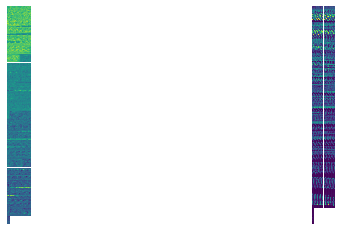

Dice:  tensor(0.9917, device='cuda:0')


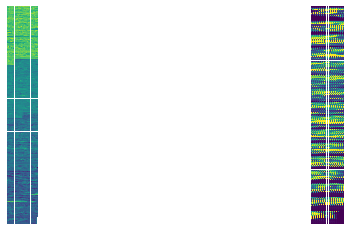

Dice:  tensor(0.9924, device='cuda:0')


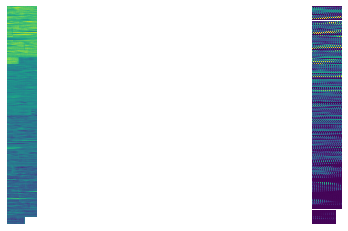

Dice:  tensor(0.9922, device='cuda:0')


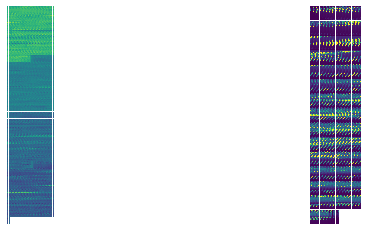

Dice:  tensor(0.9863, device='cuda:0')


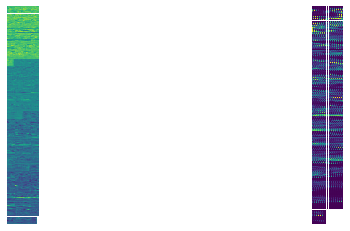

Dice:  tensor(0.9922, device='cuda:0')


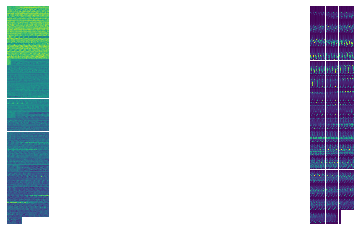

Dice:  tensor(0.9894, device='cuda:0')


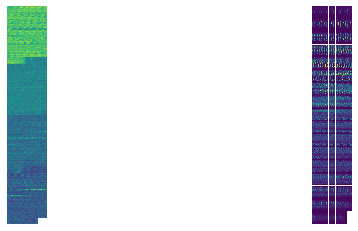

Dice:  tensor(0.9898, device='cuda:0')


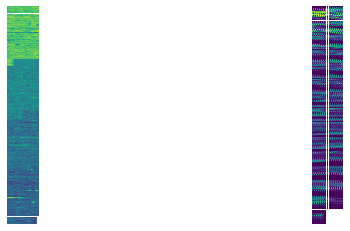

Dice:  tensor(0.9928, device='cuda:0')


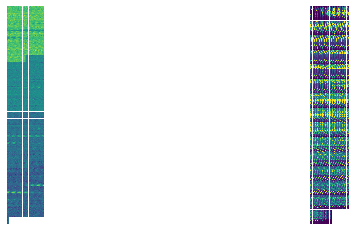

Dice:  tensor(0.9896, device='cuda:0')


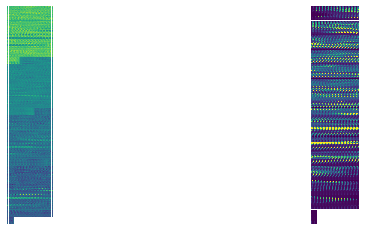

Avg Dice: 0.7289257645606995


In [24]:
from monai.visualize import matshow3d
model.eval()
with torch.no_grad():
    for val_data in test_loader:
        val_images = val_data["image"].to(device)
        val_labels = val_data["label"].to(device)
        val_labels_list = decollate_batch(val_labels)
        roi_size = (WidthLength, WidthLength)
        sw_batch_size = 3
        slice_inferer = monai.inferers.SliceInferer(
            roi_size=roi_size,
            sw_batch_size=sw_batch_size,
            spatial_dim=2,  # Spatial dim to slice along is defined here
            device=torch.device(device),
            padding_mode="replicate",
        )
        val_output = slice_inferer(val_images, model).to(device)

        val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
        val_outputs_list = decollate_batch(val_output)
        val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
        dice_metric(y_pred=val_output_convert, y=val_labels_convert)

        print("Dice: ", dice_metric.get_buffer()[-1][0])
        fig = plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        matshow3d(val_output[0], fig=plt.gca())
        plt.subplot(1, 2, 2)
        matshow3d(val_images[0], fig=plt.gca())
        plt.show()
    print(f"Avg Dice: {dice_metric.aggregate().item()}")